In [2]:
import pandas as pd
import numpy as np
from IPython.display import display

In [3]:
import pickle
data=pickle.load(open('processed_data.p', "rb" ))
data.head(3)

,Country,Location,Resource Type,floor,Department,seatName,Space,Datetime
0,India,Tower 2,Desk,Level 9,Sky Branch,B5_9_1_02,0,2018-03-01
1,India,Tower 2,Desk,Level 9,Sky Branch,B5_9_2_02,0,2018-03-01
2,India,Tower 2,Desk,Level 9,Sky Branch,B5_9_2_07,0,2018-03-01


In [4]:
trial_data=data.loc[data['seatName']=='B5_9_1_05']
print(len(trial_data))
trial_data=trial_data.sort_values(['Datetime'])
trial_data=trial_data.drop(['Country','Location','Resource Type','floor','Department','seatName'],axis=1)

4464


In [26]:
#trial_data.set_index('Datetime',inplace=True)
train_data,test_data=trial_data.loc[trial_data['Datetime']<'2018-03-25'], trial_data.loc[trial_data['Datetime']>='2018-03-25']
print(len(train_data),len(test_data))
train_array=train_data.values
test_array=test_data.values

3456 1008


In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# convert an array of values into a dataset matrix
history = [x for x in train_array]
predictions = list()
for i in range(len(test_array)):
    predictions.append(history[-1])
    history.append(test_array[i])
rmse = sqrt(mean_squared_error( [x[0] for x in test_array], [x[0] for x in predictions]))
print('RMSE: %.3f' % rmse)

RMSE: 0.252


In [28]:
test_data.set_index('Datetime',inplace=True)

In [29]:
d = {'Datetime':[x[1] for x in predictions],'Pred':[x[0] for x in predictions]}
pred_df=pd.DataFrame(d)
#pred_df=pred_df.drop([0],axis=0)
pred_df.set_index('Datetime',inplace=True)

In [30]:
plot_data=pd.concat([pred_df,test_data],axis=1)

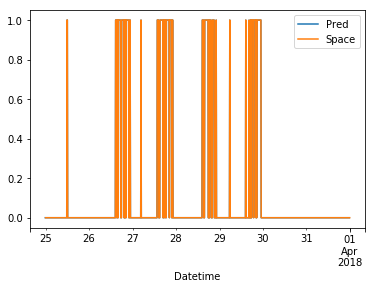

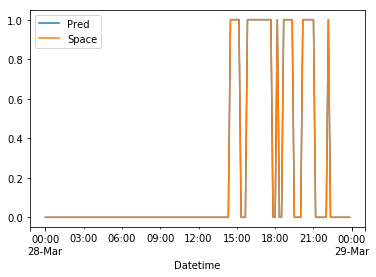

In [31]:
plot_data.plot();
one_day_plot=plot_data.loc[(plot_data.index<'2018-03-29') & (plot_data.index>='2018-03-28')]
one_day_plot.plot();

## LSTM SOLUTION

In [24]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
   # df = pd.DataFrame(data,columns=['space','date'])
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# transform to supervised learning
trial_values = trial_data.drop('Datetime',axis=1)
trial_values=trial_values.values
#X = trial_data.values
supervised = timeseries_to_supervised(trial_values, 1)
#supervised.columns=['X','Date',  'y', 'Date_shift']
supervised.columns=['X',  'y']
display(supervised.head(3))

,X,y
0,0.0,0
1,0.0,0
2,0.0,0


In [25]:
#train_data,test_data=supervised.loc[supervised['Date']<'2018-03-25'], supervised.loc[supervised['Date']>='2018-03-25']
train_data,test_data=supervised[:3456],supervised[1008:]
#train_data.drop(['Date','Date_shift'])
train_values=train_data.values
test_values=test_data.values

In [26]:
train_values

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [30]:
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Dense
from keras.layers.normalization import BatchNormalization

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    #X, y = train['X'], train['y']
    print(X.shape,X.shape[0],X.shape[1])
    X = X.reshape(X.shape[0], 1, X.shape[1])
    print(X.shape,X.shape[0],X.shape[1])
    print(batch_size, X.shape[1], X.shape[2])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    #for i in range(nb_epoch):
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False)
     #   model.reset_states()
    return model

In [34]:
batch_size=1
lstm_model = fit_lstm(train_values, batch_size, 5, 4)

(3456, 1) 3456 1
(3456, 1, 1) 3456 1
1 1 1
Epoch 1/5
3456/3456 [==============================] - 18s 5ms/step - loss: 1.9262
Epoch 2/5
3456/3456 [==============================] - 17s 5ms/step - loss: 1.9261
Epoch 3/5
3456/3456 [==============================] - 17s 5ms/step - loss: 1.9261
Epoch 4/5
3456/3456 [==============================] - 17s 5ms/step - loss: 1.9261
Epoch 5/5
3456/3456 [==============================] - 17s 5ms/step - loss: 1.9261


In [35]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(batch_size, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

predictions = list()
for i in range(len(test_values)):
    # make one-step forecast
    X, y = test_values[i, 0:-1], test_values[i, -1]
    yhat = forecast_lstm(lstm_model, batch_size, X)
    # store forecast
    predictions.append(yhat)
    expected = trial_values[len(train_values) + i + 1]
    print('Time=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Time=1, Predicted=-0.025157, Expected=0.000000
Time=2, Predicted=-0.025157, Expected=0.000000
Time=3, Predicted=-0.025157, Expected=0.000000
Time=4, Predicted=-0.025157, Expected=0.000000
Time=5, Predicted=-0.025157, Expected=0.000000
Time=6, Predicted=-0.025157, Expected=0.000000
Time=7, Predicted=-0.025157, Expected=0.000000
Time=8, Predicted=-0.025157, Expected=0.000000
Time=9, Predicted=-0.025157, Expected=0.000000
Time=10, Predicted=-0.025157, Expected=0.000000
Time=11, Predicted=-0.025157, Expected=0.000000
Time=12, Predicted=-0.025157, Expected=0.000000
Time=13, Predicted=-0.025157, Expected=0.000000
Time=14, Predicted=-0.025157, Expected=0.000000
Time=15, Predicted=-0.025157, Expected=0.000000
Time=16, Predicted=-0.025157, Expected=0.000000
Time=17, Predicted=-0.025157, Expected=0.000000
Time=18, Predicted=-0.025157, Expected=0.000000
Time=19, Predicted=-0.025157, Expected=0.000000
Time=20, Predicted=-0.025157, Expected=0.000000
Time=21, Predicted=-0.025157, Expected=0.000000
T

Time=282, Predicted=-0.025157, Expected=0.000000
Time=283, Predicted=-0.025157, Expected=0.000000
Time=284, Predicted=-0.025157, Expected=0.000000
Time=285, Predicted=-0.025157, Expected=0.000000
Time=286, Predicted=-0.025157, Expected=0.000000
Time=287, Predicted=-0.025157, Expected=0.000000
Time=288, Predicted=-0.025157, Expected=0.000000
Time=289, Predicted=-0.025157, Expected=0.000000
Time=290, Predicted=-0.025157, Expected=0.000000
Time=291, Predicted=-0.025157, Expected=0.000000
Time=292, Predicted=-0.025157, Expected=0.000000
Time=293, Predicted=-0.025157, Expected=0.000000
Time=294, Predicted=-0.012738, Expected=0.000000
Time=295, Predicted=-0.012738, Expected=0.000000
Time=296, Predicted=-0.025157, Expected=0.000000
Time=297, Predicted=-0.012738, Expected=0.000000
Time=298, Predicted=-0.025157, Expected=0.000000
Time=299, Predicted=-0.025157, Expected=0.000000
Time=300, Predicted=-0.025157, Expected=0.000000
Time=301, Predicted=-0.025157, Expected=0.000000
Time=302, Predicted=

Time=577, Predicted=-0.025157, Expected=0.000000
Time=578, Predicted=-0.025157, Expected=0.000000
Time=579, Predicted=-0.025157, Expected=0.000000
Time=580, Predicted=-0.025157, Expected=0.000000
Time=581, Predicted=-0.025157, Expected=0.000000
Time=582, Predicted=-0.025157, Expected=0.000000
Time=583, Predicted=-0.025157, Expected=0.000000
Time=584, Predicted=-0.025157, Expected=0.000000
Time=585, Predicted=-0.025157, Expected=0.000000
Time=586, Predicted=-0.025157, Expected=0.000000
Time=587, Predicted=-0.025157, Expected=0.000000
Time=588, Predicted=-0.025157, Expected=0.000000
Time=589, Predicted=-0.025157, Expected=0.000000
Time=590, Predicted=-0.025157, Expected=0.000000
Time=591, Predicted=-0.025157, Expected=0.000000
Time=592, Predicted=-0.025157, Expected=0.000000
Time=593, Predicted=-0.025157, Expected=0.000000
Time=594, Predicted=-0.025157, Expected=0.000000
Time=595, Predicted=-0.025157, Expected=0.000000
Time=596, Predicted=-0.025157, Expected=0.000000
Time=597, Predicted=

Time=852, Predicted=-0.025157, Expected=0.000000
Time=853, Predicted=-0.025157, Expected=0.000000
Time=854, Predicted=-0.025157, Expected=0.000000
Time=855, Predicted=-0.025157, Expected=0.000000
Time=856, Predicted=-0.025157, Expected=0.000000
Time=857, Predicted=-0.025157, Expected=0.000000
Time=858, Predicted=-0.025157, Expected=0.000000
Time=859, Predicted=-0.025157, Expected=0.000000
Time=860, Predicted=-0.025157, Expected=0.000000
Time=861, Predicted=-0.025157, Expected=0.000000
Time=862, Predicted=-0.025157, Expected=0.000000
Time=863, Predicted=-0.025157, Expected=0.000000
Time=864, Predicted=-0.025157, Expected=0.000000
Time=865, Predicted=-0.025157, Expected=0.000000
Time=866, Predicted=-0.025157, Expected=0.000000
Time=867, Predicted=-0.025157, Expected=0.000000
Time=868, Predicted=-0.025157, Expected=0.000000
Time=869, Predicted=-0.025157, Expected=0.000000
Time=870, Predicted=-0.025157, Expected=0.000000
Time=871, Predicted=-0.025157, Expected=0.000000
Time=872, Predicted=

IndexError: index 4464 is out of bounds for axis 0 with size 4464

In [ ]:
pyplot.plot(trial_values[1007:])
pyplot.plot(predictions)
pyplot.show()

In [85]:
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Dense
from keras.layers.normalization import BatchNormalization

def arch():
    seq = Sequential()
    seq.add(LSTM(4,input_shape=(1,look_back)))
    #seq.add(LSTM(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))
    #seq.add(BatchNormalization())
    #seq.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    #seq.add(BatchNormalization())

    seq.add(Dense(1, activation='sigmoid'))
    seq.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return seq


model=arch()
batch_size = 32
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=100,
          validation_data=(X_test, y_test))


Train on 3792 samples, validate on 668 samples
Epoch 1/100
3792/3792 [==============================] - 2s 409us/step - loss: 0.6528 - acc: 0.9536 - val_loss: 0.5957 - val_acc: 0.9985
Epoch 2/100
3792/3792 [==============================] - 1s 175us/step - loss: 0.5547 - acc: 0.9536 - val_loss: 0.4766 - val_acc: 0.9985
Epoch 3/100
3792/3792 [==============================] - 1s 179us/step - loss: 0.4422 - acc: 0.9536 - val_loss: 0.3517 - val_acc: 0.9985
Epoch 4/100
3792/3792 [==============================] - 1s 176us/step - loss: 0.3373 - acc: 0.9536 - val_loss: 0.2475 - val_acc: 0.9985
Epoch 5/100
3792/3792 [==============================] - 1s 190us/step - loss: 0.2568 - acc: 0.9536 - val_loss: 0.1738 - val_acc: 0.9985
Epoch 6/100
3792/3792 [==============================] - 1s 181us/step - loss: 0.2015 - acc: 0.9536 - val_loss: 0.1251 - val_acc: 0.9985
Epoch 7/100
3792/3792 [==============================] - 1s 189us/step - loss: 0.1645 - acc: 0.9536 - val_loss: 0.0938 - val_acc: 0

3792/3792 [==============================] - 1s 180us/step - loss: 0.0752 - acc: 0.9815 - val_loss: 0.0191 - val_acc: 0.9970
Epoch 61/100
3792/3792 [==============================] - 1s 174us/step - loss: 0.0752 - acc: 0.9815 - val_loss: 0.0190 - val_acc: 0.9970
Epoch 62/100
3792/3792 [==============================] - 1s 172us/step - loss: 0.0752 - acc: 0.9815 - val_loss: 0.0191 - val_acc: 0.9970
Epoch 63/100
3792/3792 [==============================] - 1s 171us/step - loss: 0.0752 - acc: 0.9815 - val_loss: 0.0190 - val_acc: 0.9970
Epoch 64/100
3792/3792 [==============================] - 1s 175us/step - loss: 0.0752 - acc: 0.9815 - val_loss: 0.0191 - val_acc: 0.9970
Epoch 65/100
3792/3792 [==============================] - 1s 171us/step - loss: 0.0752 - acc: 0.9815 - val_loss: 0.0191 - val_acc: 0.9970
Epoch 66/100
3792/3792 [==============================] - 1s 170us/step - loss: 0.0752 - acc: 0.9815 - val_loss: 0.0191 - val_acc: 0.9970
Epoch 67/100
3792/3792 [=======================

TypeError: predict() got multiple values for argument 'batch_size'

In [86]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

668/668 [==============================] - 0s 92us/step
Test score: 0.019003981066321184
Test accuracy: 0.9970059880239521


In [93]:
# make predictions
import math
from sklearn.metrics import mean_squared_error
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
plt.plot(trainPredict)
plt.plot(trial_data['Space'][:])

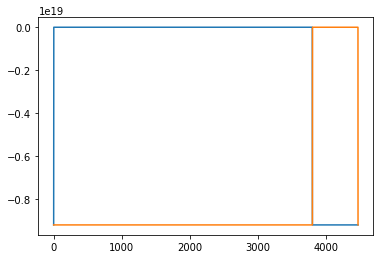

In [97]:
# shift train predictions for plotting
import matplotlib.pyplot as plt
trainPredictPlot = np.empty_like(trial_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(trial_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(trial_data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()